# University of Notre Dame 
# Students: 
* Bryan Piguave
* Thomas Burton 
## Ising Model Project
This Jupyter notebook simulates the 2D Ising model to calculate various observables such as magnetization, energy, susceptibility as functions of temperature. The Hamiltonian is defined as follows: 


$ \mathcal{H} = -J \sum_{\langle i, j \rangle} S_i S_j - H \sum_{i} S_i $
 where $S_{i}$ is the spin of an element of the lattice.

# Question A 

Show that your random number generator is reliable. That is, does it yield independent, identically distributed random variables, uniformly distributed in the interval [0,1]

# Answer to Question A

Average of random numbers: 0.49890167520075096
Standard deviation of random numbers: 0.28913340440985297
Relative error: 0.22%


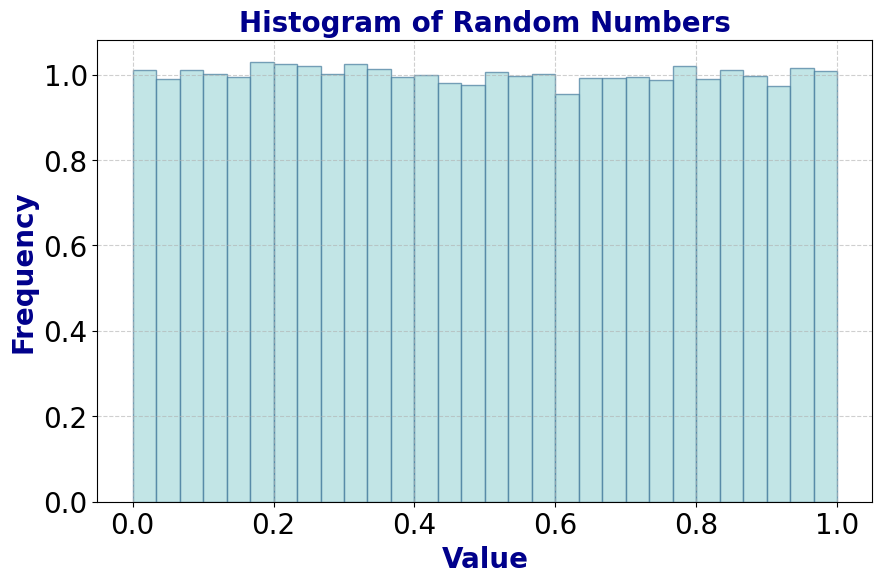

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
font_dict = {'family': 'sans-serif', 'color': 'darkblue', 'weight': 'bold', 'size': 20}
def main():
    # Generate 100000 random numbers between 0 and 1
    random_numbers = np.random.rand(100000)
    plt.figure(figsize=(10, 6))
    plt.hist(random_numbers, bins=30, density=True, alpha=0.7, color='#a8dadc', edgecolor='#457b9d')
    plt.title('Histogram of Random Numbers', fontdict=font_dict)
    plt.xlabel('Value', fontdict=font_dict)
    plt.ylabel('Frequency', fontdict=font_dict)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig('random_numbers_histogram_soft.png')
    # Average of the random numbers
    average = np.mean(random_numbers)
    print(f"Average of random numbers: {average}")
    # Standard deviation of the random numbers
    std_dev = np.std(random_numbers)
    print(f"Standard deviation of random numbers: {std_dev}")
    # Relative error compared to the expected value of 0.5
    relative_error = 100 * abs(average - 0.5) / 0.5
    print(f"Relative error: {relative_error:.2f}%")
    return 0
if __name__ == "__main__":
    main()

# Question B

Write a code for the 2 dimensional Ising model, with H = 0. Explain briefly the Monte Carlo method. Explain the main ideas of the code, the clever ideas that save computation time, etc. Discuss briefly the expected effects of boundary conditions. What boundary conditions did you choose?

# Answer to question B

### Ising2D class

For this project, we created a class called Ising 2D. We initialize the model using an LxL lattice. Therefore, the model object starts with the following attributes:
* L : Linear size of the square lattice 
* Initial_state: a string value that allows us to choose how we would like the spins to be oriented at the beginning (all up, all down or random)
* H: External magnetic field strength 
* J: Interaction magnetic field strength 
The class Ising2D contains several methods to calculate the energy, magnetization, 
and the Monte Carlo Step to run the simulation.


We use the periodic boundary conditions to solve this problem. 
In the function, get_neighbors_sum_numba(), we use the modulus operator to emulate that condition. 

get_neighbors_sum_numba: Calculates the sum of neighboring spins.
calculate_delta_E_numba: Calculates the energy change upon flipping a spin.
monte_carlo_step_numba: Performs the core Metropolis algorithm steps.
calculate_energy_numba: Calculates the total energy of the lattice.
calculate_magnetization_numba: Calculates the total magnetization.

### Computational improvements 
To make Python code faster, we decided to use the numba library which basically, compiles Python functions directly to efficent machine code, bypassing th Python interpreter's overhead.
Inside the Numba-compiled monte_carlo_step_numba, we use random.randrange(L) instead of np.random.randint(L) for generating random indices. 
For single integer generation within a loop, the built-in random module can be faster within a Numba-compiled function.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import numba
@numba.jit(nopython=True)
def get_neighbors_sum_numba(lattice, L, i, j):
    """
    Numba-optimized function to calculate the sum of the nearest neighbor spins
    for site (i, j) using periodic boundary conditions.
    """
    top = lattice[(i - 1) % L, j]
    bottom = lattice[(i + 1) % L, j]
    left = lattice[i, (j - 1) % L]
    right = lattice[i, (j + 1) % L]
    return top + bottom + left + right
@numba.jit(nopython=True)
def calculate_delta_E_numba(lattice, L, J, H, i, j):
    """
    Numba-optimized function to calculate the change in energy if the spin
    at (i, j) is flipped.
    ΔE = 2 * s_ij * (J * sum_neighbors + H)
    """
    spin_ij = lattice[i, j]
    neighbors_sum = get_neighbors_sum_numba(lattice, L, i, j)
    delta_E = 2 * spin_ij * (J * neighbors_sum + H)
    return delta_E
def monte_carlo_step_fully_vectorized(lattice, L, N, J, H, beta):
    """
    Fully vectorized Monte Carlo step for the Metropolis algorithm.
    Performs N attempted spin flips in a single batch.
    """
    # 1. Generate random indices for spin sites
    i_indices = np.random.randint(0, L, size=N)
    j_indices = np.random.randint(0, L, size=N)   
    # 2. Calculate delta_E for all flips in batch (vectorized)
    # Get all neighbors at once using periodic boundary conditions
    i_up = (i_indices - 1) % L
    i_down = (i_indices + 1) % L
    j_left = (j_indices - 1) % L
    j_right = (j_indices + 1) % L
    # Current spins at the selected positions
    current_spins = lattice[i_indices, j_indices]    
    # Sum of neighboring spins
    neighbor_sum = (lattice[i_up, j_indices] + lattice[i_down, j_indices] + 
                    lattice[i_indices, j_left] + lattice[i_indices, j_right])
    # Delta E calculation: 2 * spin * (J * sum_neighbors + H)
    delta_Es = 2 * current_spins * (J * neighbor_sum + H)
    # 3. Calculate acceptance probabilities
    acceptance_probs = np.exp(-delta_Es * beta)
    random_values = np.random.random(N)
    # 4. Determine which spins to flip
    flip_mask = (delta_Es < 0) | (random_values < acceptance_probs)
    # 5. Flip spins in a single operation
    lattice[i_indices[flip_mask], j_indices[flip_mask]] *= -1
    return lattice

def calculate_energy_vectorized_lowmem(lattice, L, J, H):
    """
    Vectorized version with reduced memory usage
    """
    # Calculate right and down neighbor sums in one operation
    neighbor_sum = np.roll(lattice, -1, axis=1) + np.roll(lattice, -1, axis=0)
    # Compute both energy terms
    interaction_energy = -J * np.sum(lattice * neighbor_sum)
    field_energy = -H * np.sum(lattice)
    return interaction_energy + field_energy

@numba.jit(nopython=True)
def calculate_magnetization_numba(lattice):
    """
    Numba-optimized function to calculate the total magnetization of the lattice.
    M = Σ_i s_i
    """
    return np.sum(lattice)

class Ising2D:
    """
    Implements a 2D Ising model simulation using the Metropolis Monte Carlo algorithm.
    Optimized with Numba for speed.
    """
    def __init__(self, L, initial_state='random', J=1.0, H=0.0):
        """
        Initializes the Ising model on an LxL lattice.

        Args:
            L (int): Linear size of the square lattice.
            initial_state (str): 'random' for random initial spins, 'up' for all spins +1,
                                    'down' for all spins -1.
            J (float): Interaction strength (J > 0 for ferromagnetic).
            H (float): External magnetic field strength.
        """
        self.L = L
        self.N = L * L  # Total number of spins
        self.J = J
        self.H = H

        if initial_state == 'random':
            self.lattice = np.random.choice([1, -1], size=(L, L))
            self.lattice = self.lattice.astype(np.int8)  # Uses only 1 byte per spin
        elif initial_state == 'up':
            self.lattice = np.ones((L, L), dtype=np.int8)
        elif initial_state == 'down':
            self.lattice = -np.ones((L, L), dtype=np.int8)
        else:
            raise ValueError("initial_state must be 'random', 'up', or 'down'")

    def monte_carlo_step(self, beta):
        """
        Performs one Monte Carlo step using the Metropolis algorithm, optimized with Numba.
        One step consists of N attempted spin flips (where N = L*L).

        Args:
            beta (float): Inverse temperature (1 / (k_B * T)). k_B is assumed to be 1.
        """
        self.lattice = monte_carlo_step_fully_vectorized(self.lattice, self.L, self.N, self.J, self.H, beta)

    def calculate_energy(self):
        """
        Calculates the total energy of the lattice using the Numba-optimized function.
        E = -J Σ_<i,j> s_i s_j - H Σ_i s_i
        The sum Σ_<i,j> is over nearest neighbor pairs (each pair counted once).
        """
        return calculate_energy_vectorized_lowmem(self.lattice, self.L, self.J, self.H)

    def calculate_magnetization(self):
        """
        Calculates the total magnetization of the lattice using the Numba-optimized function.
        M = Σ_i s_i
        """
        return calculate_magnetization_numba(self.lattice)

    def run_simulation(self, T, num_steps:600, equilibration_steps=500):
        """
        Runs the Monte Carlo simulation for a given temperature.

        Args:
            T (float): Temperature (k_B is assumed to be 1).
            num_steps (int): Total number of Monte Carlo steps (each step = N spin flips).
            equilibration_steps (int): Number of initial steps to discard for equilibration.

        Returns:
            tuple: (energies, magnetizations)
                   - energies (list): List of total energy per site (E/N) at each step after equilibration.
                   - magnetizations (list): List of magnetization per site (M/N) at each step after equilibration.
        """
        if T <= 0:
            if T == 0:
                beta = np.inf
            else:
                raise ValueError("Temperature must be positive.")
        else:
            beta = 1.0 / T
        # Pre-allocate arrays for results
        energies = np.empty(num_steps - equilibration_steps)    
        magnetizations = np.empty(num_steps - equilibration_steps)
        print(f"Equilibrating for {equilibration_steps} steps at T={T:.2f}...")
        for _ in tqdm(range(equilibration_steps), desc="Equilibration"):
            self.monte_carlo_step(beta)

        print(f"Running simulation for {num_steps - equilibration_steps} steps at T={T:.2f}...")
        for step in tqdm(range(num_steps - equilibration_steps), desc="Simulation"):
            self.monte_carlo_step(beta)
            energy = self.calculate_energy()
            magnetization = self.calculate_magnetization()
            energies[step] = energy / self.N
            magnetizations[step] = magnetization / self.N

        return energies, magnetizations

    def get_lattice(self):
        """
        Returns the current state of the lattice.
        """
        return self.lattice.copy()



# Average Spin Trajectory 

In [9]:
# --- Analysis Functions ---
def get_average_spin_trajectory(L=20, T=2.0, num_steps=1000, equilibration_steps=500):
    """
    Simulates the Ising model and returns the trajectory of the
    average magnetization per site after equilibration.

    Args:
        L (int): Lattice size.
        T (float): Temperature.
        num_steps (int): Total simulation steps.
        equilibration_steps (int): Steps to discard for equilibration.

    Returns:
        list: Trajectory of average magnetization per site (M/N) after equilibration.
    """
    print(f"--- Starting trajectory simulation for L={L}, T={T:.2f} ---")
    model = Ising2D(L=L, initial_state='random')
    _, magnetizations = model.run_simulation(T, num_steps, equilibration_steps)
    print(f"--- Finished trajectory simulation ---")
    return magnetizations # This is M/N trajectory

def plot_average_spin_trajectory(trajectory, T):
    """
    Plots the average magnetization per site trajectory.

    Args:
        trajectory (list): List of average magnetization per site values.
        T (float): Temperature at which the simulation was run.
    """
    plt.figure(figsize=(12, 8))
    steps = np.arange(len(trajectory))
    plt.plot(steps, trajectory, label=f'T = {T:.2f}')
    plt.xlabel('Monte Carlo Steps (after equilibration)',fontdict=font_dict)
    plt.ylabel('Average Magnetization per Site (M/N)', fontdict = font_dict)
    plt.title('Average Magnetization Trajectory', font_dict)
    # Calculate and display the mean and std dev of the trajectory
    mean_M = np.mean(trajectory)
    std_M = np.std(trajectory)
    plt.axhline(mean_M, color='#ae9142', linestyle='--', label=f'Mean = {mean_M:.4f}')
    plt.text(0.05, 0.95, f'Std Dev = {std_M:.4f}', transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.ylim(min(trajectory)-0.1*abs(min(trajectory)), max(trajectory)+0.1*abs(max(trajectory))) # Adjust y-lim slightly
    plt.show()



# Question C
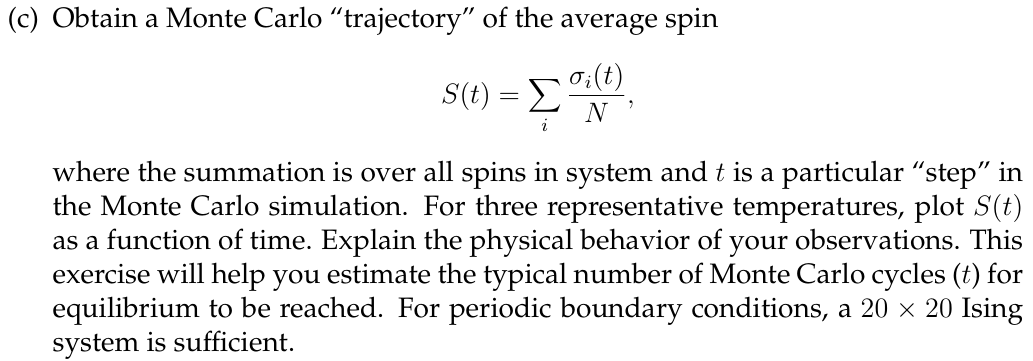


--- Ising Model Simulation ---

Simulating spin trajectory...
--- Starting trajectory simulation for L=20, T=2.27 ---
Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 16428.67it/s]


Running simulation for 1000 steps at T=2.27...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 12451.55it/s]

--- Finished trajectory simulation ---


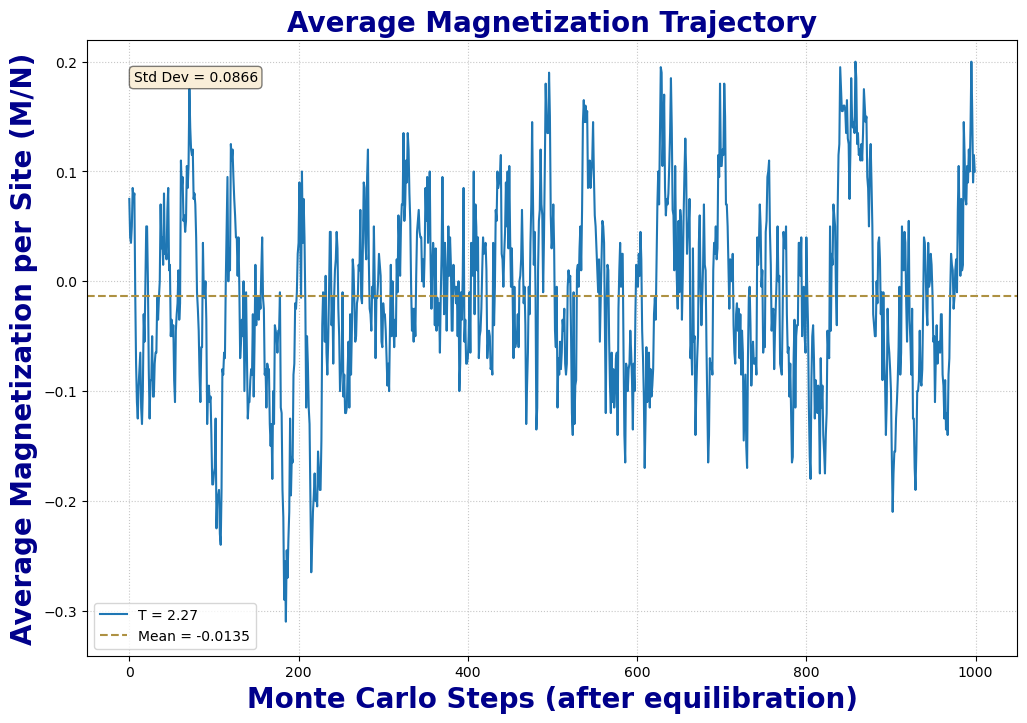

In [10]:
# --- Main execution block (Example Usage) ---
print("--- Ising Model Simulation ---")
# Simulate and plot average spin trajectory near Tc
print("\nSimulating spin trajectory...")
L_traj = 20
T_traj = 2.27 # Near Tc
traj_steps = 2000
traj_eq_steps = 1000
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)

--- Starting trajectory simulation for L=20, T=1.50 ---
Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 19211.11it/s]


Running simulation for 1000 steps at T=1.50...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 15379.52it/s]

--- Finished trajectory simulation ---


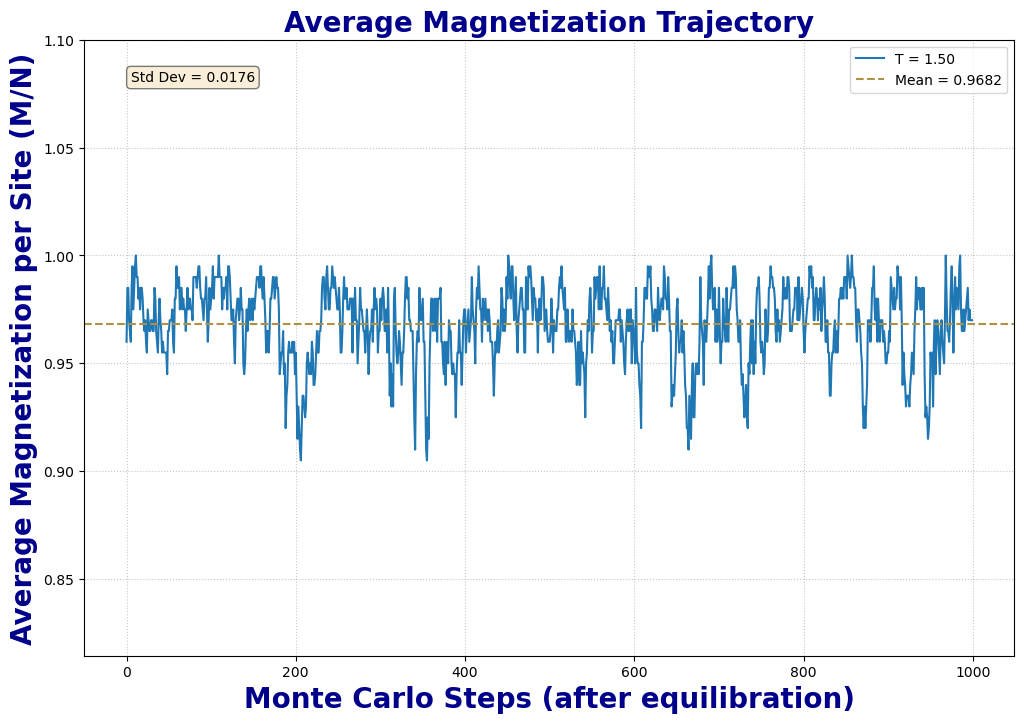

In [11]:
T_traj = 1.5 # Ferromagnetic phase
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)


--- Starting trajectory simulation for L=20, T=3.00 ---
Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 15994.94it/s]


Running simulation for 1000 steps at T=3.00...


Simulation: 100%|██████████| 1000/1000 [00:00<00:00, 14418.57it/s]

--- Finished trajectory simulation ---


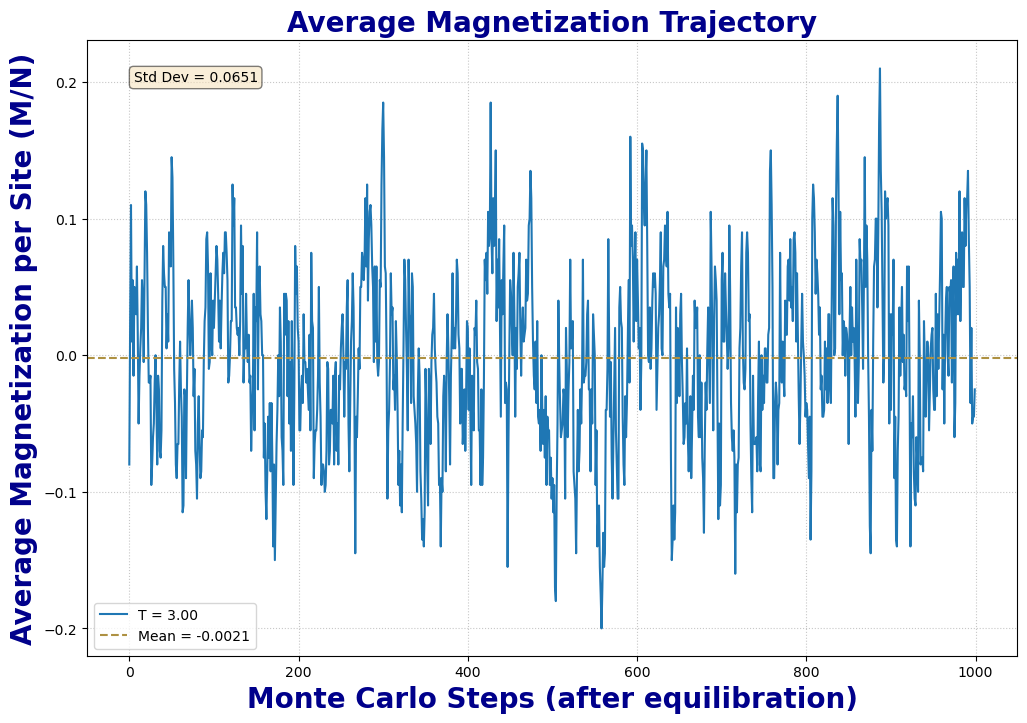

In [12]:
T_traj = 3.0 # Paramagnetic phase
avg_spin_traj = get_average_spin_trajectory(L=L_traj, T=T_traj, num_steps=traj_steps, equilibration_steps=traj_eq_steps)
plot_average_spin_trajectory(avg_spin_traj, T_traj)

# Question D
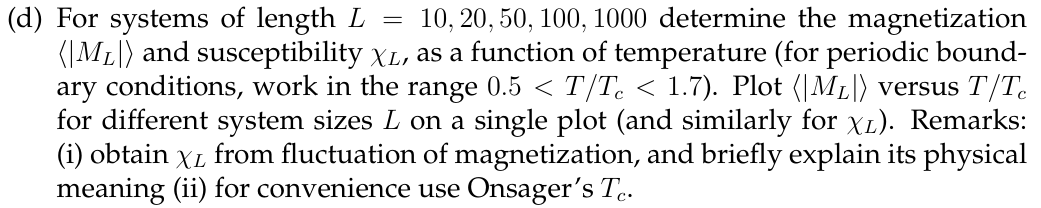

# Question E

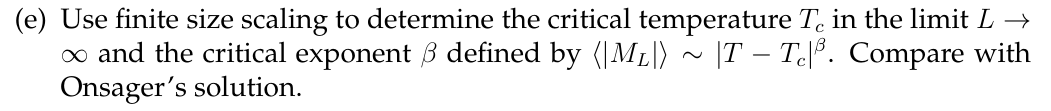

In [9]:
# 4. Estimate Critical Temperature
print("\nEstimating Critical Temperature...")
Tc_est = estimate_critical_temperature_and_gamma(
    L_values = L_values_analysis,
    T_range = T_range_analysis, # Use the same T range for consistency
    num_steps = 5000, # Match steps used in plot function or adjust
    equilibration_steps = 1000
)
if Tc_est is not None:
    Tc_exact = 2 / np.log(1 + np.sqrt(2))
    print(f"Comparison: Exact Tc (infinite lattice) ≈ {Tc_exact:.4f}")


Estimating Critical Temperature...

--- Calculating Susceptibility for Tc Estimation ---


Estimating Tc (L=8):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 65178.54it/s]


Running simulation for 4000 steps at T=1.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 80043.97it/s]


Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 94769.40it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=8):   5%|▌         | 2/40 [00:00<00:02, 13.13it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 75480.56it/s]


Running simulation for 4000 steps at T=1.20...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 84004.95it/s]


Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 73306.49it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=8):  10%|█         | 4/40 [00:00<00:02, 12.55it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 115714.51it/s]


Running simulation for 4000 steps at T=1.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 85882.86it/s]


Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 100195.98it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=8):  15%|█▌        | 6/40 [00:00<00:02, 13.00it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 80390.69it/s]


Running simulation for 4000 steps at T=1.60...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 109501.13it/s]


Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 139987.45it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=8):  20%|██        | 8/40 [00:00<00:02, 14.04it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 282501.78it/s]


Running simulation for 4000 steps at T=1.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 77826.87it/s]


Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 88453.84it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=8):  25%|██▌       | 10/40 [00:00<00:02, 13.44it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 61601.22it/s]


Running simulation for 4000 steps at T=2.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 90421.28it/s]


Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 77412.82it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=8):  30%|███       | 12/40 [00:00<00:02, 12.57it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 66934.30it/s]


Running simulation for 4000 steps at T=2.07...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 84858.99it/s]


Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 54933.78it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=8):  35%|███▌      | 14/40 [00:01<00:02, 12.27it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 87463.33it/s]


Running simulation for 4000 steps at T=2.12...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 61216.19it/s]


Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 133444.82it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=8):  40%|████      | 16/40 [00:01<00:02, 11.88it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 67565.06it/s]


Running simulation for 4000 steps at T=2.17...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 95657.17it/s]


Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 54603.38it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=8):  45%|████▌     | 18/40 [00:01<00:02, 10.48it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 72369.24it/s]


Running simulation for 4000 steps at T=2.22...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 54833.06it/s]


Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 74355.23it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=8):  50%|█████     | 20/40 [00:01<00:01, 10.37it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 83288.07it/s]


Running simulation for 4000 steps at T=2.27...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 80605.83it/s]


Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 86150.10it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=8):  55%|█████▌    | 22/40 [00:01<00:01, 11.08it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 100157.70it/s]


Running simulation for 4000 steps at T=2.32...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 99637.23it/s]


Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 111571.41it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=8):  60%|██████    | 24/40 [00:02<00:01, 12.01it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 121945.17it/s]


Running simulation for 4000 steps at T=2.38...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 90474.92it/s]


Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 70181.11it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=8):  65%|██████▌   | 26/40 [00:02<00:01, 12.65it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 99252.32it/s]


Running simulation for 4000 steps at T=2.42...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 99654.99it/s]


Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 77089.84it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=8):  70%|███████   | 28/40 [00:02<00:00, 12.48it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 76339.19it/s]


Running simulation for 4000 steps at T=2.47...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 64005.62it/s]


Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 60768.52it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=8):  75%|███████▌  | 30/40 [00:02<00:00, 11.88it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 96279.13it/s]


Running simulation for 4000 steps at T=2.52...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 68926.88it/s]


Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 70344.72it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=8):  80%|████████  | 32/40 [00:02<00:00, 10.29it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 64679.00it/s]

Running simulation for 4000 steps at T=2.60...



Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 64841.74it/s]


Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 45077.26it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=8):  85%|████████▌ | 34/40 [00:02<00:00, 10.15it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 65618.02it/s]


Running simulation for 4000 steps at T=3.00...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 95623.37it/s]

Equilibrating for 1000 steps at T=3.20...

Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 97662.33it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=8):  90%|█████████ | 36/40 [00:03<00:00, 10.94it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 98880.29it/s]


Running simulation for 4000 steps at T=3.40...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 94400.93it/s]


Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 67841.55it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=8):  95%|█████████▌| 38/40 [00:03<00:00, 11.56it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 111057.38it/s]


Running simulation for 4000 steps at T=3.80...


Simulation: 100%|██████████| 4000/4000 [00:00<00:00, 53676.79it/s]


Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 60896.45it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=16):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 23535.74it/s]


Running simulation for 4000 steps at T=1.00...


Estimating Tc (L=16):   2%|▎         | 1/40 [00:00<00:07,  4.90it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30854.54it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=16):   5%|▌         | 2/40 [00:00<00:07,  5.13it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33114.41it/s]

Running simulation for 4000 steps at T=1.20...



Estimating Tc (L=16):   8%|▊         | 3/40 [00:00<00:06,  5.42it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31189.52it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=16):  10%|█         | 4/40 [00:00<00:06,  5.36it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33127.75it/s]


Running simulation for 4000 steps at T=1.40...


Estimating Tc (L=16):  12%|█▎        | 5/40 [00:00<00:06,  5.25it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25758.47it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=16):  15%|█▌        | 6/40 [00:01<00:07,  4.52it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25049.74it/s]


Running simulation for 4000 steps at T=1.60...


Estimating Tc (L=16):  18%|█▊        | 7/40 [00:01<00:07,  4.71it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 35572.99it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=16):  20%|██        | 8/40 [00:01<00:06,  5.06it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 41590.77it/s]

Running simulation for 4000 steps at T=1.80...



Estimating Tc (L=16):  22%|██▎       | 9/40 [00:01<00:05,  5.41it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33829.94it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=16):  25%|██▌       | 10/40 [00:01<00:05,  5.62it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 38021.16it/s]


Running simulation for 4000 steps at T=2.00...


Estimating Tc (L=16):  28%|██▊       | 11/40 [00:02<00:04,  6.06it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32441.56it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=16):  30%|███       | 12/40 [00:02<00:04,  5.94it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33549.33it/s]


Running simulation for 4000 steps at T=2.07...


Estimating Tc (L=16):  32%|███▎      | 13/40 [00:02<00:04,  6.02it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 28367.49it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=16):  35%|███▌      | 14/40 [00:02<00:04,  5.89it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25697.56it/s]


Running simulation for 4000 steps at T=2.12...


Estimating Tc (L=16):  38%|███▊      | 15/40 [00:02<00:04,  5.70it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 36613.89it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=16):  40%|████      | 16/40 [00:02<00:04,  5.71it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30732.91it/s]


Running simulation for 4000 steps at T=2.17...


Estimating Tc (L=16):  42%|████▎     | 17/40 [00:03<00:03,  5.80it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40494.16it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=16):  45%|████▌     | 18/40 [00:03<00:03,  6.15it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 28883.41it/s]


Running simulation for 4000 steps at T=2.22...


Estimating Tc (L=16):  48%|████▊     | 19/40 [00:03<00:03,  6.42it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32970.46it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=16):  50%|█████     | 20/40 [00:03<00:03,  6.32it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 33784.71it/s]


Running simulation for 4000 steps at T=2.27...


Estimating Tc (L=16):  52%|█████▎    | 21/40 [00:03<00:02,  6.46it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39848.60it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=16):  55%|█████▌    | 22/40 [00:03<00:02,  6.65it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39562.93it/s]


Running simulation for 4000 steps at T=2.32...


Estimating Tc (L=16):  57%|█████▊    | 23/40 [00:03<00:02,  6.94it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 14251.26it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=16):  60%|██████    | 24/40 [00:04<00:02,  5.62it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31301.94it/s]


Running simulation for 4000 steps at T=2.38...


Estimating Tc (L=16):  62%|██████▎   | 25/40 [00:04<00:02,  5.76it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39869.43it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=16):  65%|██████▌   | 26/40 [00:04<00:02,  5.95it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40329.85it/s]


Running simulation for 4000 steps at T=2.42...


Estimating Tc (L=16):  68%|██████▊   | 27/40 [00:04<00:02,  5.97it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31655.60it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=16):  70%|███████   | 28/40 [00:04<00:02,  5.92it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 39683.84it/s]


Running simulation for 4000 steps at T=2.47...


Estimating Tc (L=16):  72%|███████▎  | 29/40 [00:05<00:01,  5.84it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 31009.88it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=16):  75%|███████▌  | 30/40 [00:05<00:01,  5.83it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30944.22it/s]


Running simulation for 4000 steps at T=2.52...


Estimating Tc (L=16):  78%|███████▊  | 31/40 [00:05<00:01,  6.04it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 40405.22it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=16):  80%|████████  | 32/40 [00:05<00:01,  6.10it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 29946.05it/s]


Running simulation for 4000 steps at T=2.60...


Estimating Tc (L=16):  82%|████████▎ | 33/40 [00:05<00:01,  5.92it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 32028.10it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=16):  85%|████████▌ | 34/40 [00:05<00:01,  5.03it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 19343.12it/s]


Running simulation for 4000 steps at T=3.00...


Estimating Tc (L=16):  88%|████████▊ | 35/40 [00:06<00:01,  4.61it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30808.76it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=16):  90%|█████████ | 36/40 [00:06<00:00,  4.77it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 20560.72it/s]


Running simulation for 4000 steps at T=3.40...


Estimating Tc (L=16):  92%|█████████▎| 37/40 [00:06<00:00,  4.70it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 30793.60it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=16):  95%|█████████▌| 38/40 [00:06<00:00,  4.82it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 25260.50it/s]


Running simulation for 4000 steps at T=3.80...


Estimating Tc (L=16):  98%|█████████▊| 39/40 [00:07<00:00,  4.53it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 22046.86it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=32):   0%|          | 0/40 [00:00<?, ?it/s]

Equilibrating for 1000 steps at T=1.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7403.37it/s]


Running simulation for 4000 steps at T=1.00...


Estimating Tc (L=32):   2%|▎         | 1/40 [00:00<00:23,  1.68it/s]

Equilibrating for 1000 steps at T=1.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11245.72it/s]


Running simulation for 4000 steps at T=1.10...


Estimating Tc (L=32):   5%|▌         | 2/40 [00:01<00:19,  1.94it/s]

Equilibrating for 1000 steps at T=1.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12491.78it/s]


Running simulation for 4000 steps at T=1.20...


Estimating Tc (L=32):   8%|▊         | 3/40 [00:01<00:19,  1.90it/s]

Equilibrating for 1000 steps at T=1.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10876.86it/s]


Running simulation for 4000 steps at T=1.30...


Estimating Tc (L=32):  10%|█         | 4/40 [00:02<00:19,  1.83it/s]

Equilibrating for 1000 steps at T=1.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11212.29it/s]


Running simulation for 4000 steps at T=1.40...


Estimating Tc (L=32):  12%|█▎        | 5/40 [00:02<00:18,  1.94it/s]

Equilibrating for 1000 steps at T=1.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 12698.97it/s]


Running simulation for 4000 steps at T=1.50...


Estimating Tc (L=32):  15%|█▌        | 6/40 [00:03<00:18,  1.89it/s]

Equilibrating for 1000 steps at T=1.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 11766.15it/s]


Running simulation for 4000 steps at T=1.60...


Estimating Tc (L=32):  18%|█▊        | 7/40 [00:03<00:16,  1.98it/s]

Equilibrating for 1000 steps at T=1.70...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13300.18it/s]


Running simulation for 4000 steps at T=1.70...


Estimating Tc (L=32):  20%|██        | 8/40 [00:04<00:15,  2.09it/s]

Equilibrating for 1000 steps at T=1.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 13275.13it/s]


Running simulation for 4000 steps at T=1.80...


Estimating Tc (L=32):  22%|██▎       | 9/40 [00:04<00:16,  1.88it/s]

Equilibrating for 1000 steps at T=1.90...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10405.22it/s]


Running simulation for 4000 steps at T=1.90...


Estimating Tc (L=32):  25%|██▌       | 10/40 [00:05<00:15,  1.90it/s]

Equilibrating for 1000 steps at T=2.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9551.35it/s]


Running simulation for 4000 steps at T=2.00...


Estimating Tc (L=32):  28%|██▊       | 11/40 [00:05<00:15,  1.89it/s]

Equilibrating for 1000 steps at T=2.05...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8720.71it/s]


Running simulation for 4000 steps at T=2.05...


Estimating Tc (L=32):  30%|███       | 12/40 [00:06<00:15,  1.87it/s]

Equilibrating for 1000 steps at T=2.07...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10520.95it/s]


Running simulation for 4000 steps at T=2.07...


Estimating Tc (L=32):  32%|███▎      | 13/40 [00:06<00:14,  1.91it/s]

Equilibrating for 1000 steps at T=2.10...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9070.24it/s]


Running simulation for 4000 steps at T=2.10...


Estimating Tc (L=32):  35%|███▌      | 14/40 [00:07<00:15,  1.63it/s]

Equilibrating for 1000 steps at T=2.12...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7684.89it/s]


Running simulation for 4000 steps at T=2.12...


Estimating Tc (L=32):  38%|███▊      | 15/40 [00:08<00:15,  1.59it/s]

Equilibrating for 1000 steps at T=2.15...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7713.85it/s]


Running simulation for 4000 steps at T=2.15...


Estimating Tc (L=32):  40%|████      | 16/40 [00:08<00:15,  1.58it/s]

Equilibrating for 1000 steps at T=2.17...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10394.26it/s]


Running simulation for 4000 steps at T=2.17...


Estimating Tc (L=32):  42%|████▎     | 17/40 [00:09<00:13,  1.65it/s]

Equilibrating for 1000 steps at T=2.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7291.77it/s]


Running simulation for 4000 steps at T=2.20...


Estimating Tc (L=32):  45%|████▌     | 18/40 [00:10<00:14,  1.51it/s]

Equilibrating for 1000 steps at T=2.22...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10512.22it/s]


Running simulation for 4000 steps at T=2.22...


Estimating Tc (L=32):  48%|████▊     | 19/40 [00:10<00:13,  1.61it/s]

Equilibrating for 1000 steps at T=2.25...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10672.83it/s]


Running simulation for 4000 steps at T=2.25...


Estimating Tc (L=32):  50%|█████     | 20/40 [00:11<00:12,  1.64it/s]

Equilibrating for 1000 steps at T=2.27...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9085.78it/s]


Running simulation for 4000 steps at T=2.27...


Estimating Tc (L=32):  52%|█████▎    | 21/40 [00:11<00:11,  1.68it/s]

Equilibrating for 1000 steps at T=2.30...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9096.28it/s]


Running simulation for 4000 steps at T=2.30...


Estimating Tc (L=32):  55%|█████▌    | 22/40 [00:12<00:10,  1.69it/s]

Equilibrating for 1000 steps at T=2.32...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9099.66it/s]


Running simulation for 4000 steps at T=2.32...


Estimating Tc (L=32):  57%|█████▊    | 23/40 [00:13<00:10,  1.59it/s]

Equilibrating for 1000 steps at T=2.35...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 6878.58it/s]


Running simulation for 4000 steps at T=2.35...


Estimating Tc (L=32):  60%|██████    | 24/40 [00:14<00:10,  1.49it/s]

Equilibrating for 1000 steps at T=2.38...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8730.40it/s]


Running simulation for 4000 steps at T=2.38...


Estimating Tc (L=32):  62%|██████▎   | 25/40 [00:14<00:09,  1.57it/s]

Equilibrating for 1000 steps at T=2.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10465.48it/s]


Running simulation for 4000 steps at T=2.40...


Estimating Tc (L=32):  65%|██████▌   | 26/40 [00:15<00:08,  1.58it/s]

Equilibrating for 1000 steps at T=2.42...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7932.02it/s]


Running simulation for 4000 steps at T=2.42...


Estimating Tc (L=32):  68%|██████▊   | 27/40 [00:15<00:08,  1.60it/s]

Equilibrating for 1000 steps at T=2.45...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 9560.28it/s]


Running simulation for 4000 steps at T=2.45...


Estimating Tc (L=32):  70%|███████   | 28/40 [00:16<00:08,  1.37it/s]

Equilibrating for 1000 steps at T=2.47...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7080.70it/s]


Running simulation for 4000 steps at T=2.47...


Estimating Tc (L=32):  72%|███████▎  | 29/40 [00:17<00:08,  1.37it/s]

Equilibrating for 1000 steps at T=2.50...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8252.70it/s]


Running simulation for 4000 steps at T=2.50...


Estimating Tc (L=32):  75%|███████▌  | 30/40 [00:18<00:06,  1.43it/s]

Equilibrating for 1000 steps at T=2.52...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 7806.90it/s]


Running simulation for 4000 steps at T=2.52...


Estimating Tc (L=32):  78%|███████▊  | 31/40 [00:18<00:06,  1.45it/s]

Equilibrating for 1000 steps at T=2.55...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8253.90it/s]


Running simulation for 4000 steps at T=2.55...


Estimating Tc (L=32):  80%|████████  | 32/40 [00:19<00:05,  1.37it/s]

Equilibrating for 1000 steps at T=2.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 4975.37it/s]


Running simulation for 4000 steps at T=2.60...


Estimating Tc (L=32):  82%|████████▎ | 33/40 [00:20<00:05,  1.33it/s]

Equilibrating for 1000 steps at T=2.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 3746.61it/s]


Running simulation for 4000 steps at T=2.80...


Estimating Tc (L=32):  85%|████████▌ | 34/40 [00:21<00:04,  1.30it/s]

Equilibrating for 1000 steps at T=3.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8357.57it/s]


Running simulation for 4000 steps at T=3.00...


Estimating Tc (L=32):  88%|████████▊ | 35/40 [00:21<00:03,  1.41it/s]

Equilibrating for 1000 steps at T=3.20...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 10505.38it/s]


Running simulation for 4000 steps at T=3.20...


Estimating Tc (L=32):  90%|█████████ | 36/40 [00:22<00:02,  1.53it/s]

Equilibrating for 1000 steps at T=3.40...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8674.07it/s]


Running simulation for 4000 steps at T=3.40...


Estimating Tc (L=32):  92%|█████████▎| 37/40 [00:22<00:01,  1.52it/s]

Equilibrating for 1000 steps at T=3.60...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 4816.74it/s]


Running simulation for 4000 steps at T=3.60...


Estimating Tc (L=32):  95%|█████████▌| 38/40 [00:24<00:01,  1.17it/s]

Equilibrating for 1000 steps at T=3.80...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 3811.47it/s]


Running simulation for 4000 steps at T=3.80...


Estimating Tc (L=32):  98%|█████████▊| 39/40 [00:25<00:00,  1.17it/s]

Equilibrating for 1000 steps at T=4.00...


Equilibration: 100%|██████████| 1000/1000 [00:00<00:00, 8272.97it/s]


Running simulation for 4000 steps at T=4.00...


Estimating Tc (L=32): 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


Estimated Critical Temperature (Tc) from peak of χ for L=32: 2.3000
Peak Susceptibility (χ/N) at L=32: 127.5572

To estimate gamma (γ):
1. Find the peak susceptibility (χ_max) for each lattice size L.
2. Plot log(χ_max) against log(L).
3. The slope of this plot (for large L) approximates γ (since ν=1 in 2D Ising).
Comparison: Exact Tc (infinite lattice) ≈ 2.2692


# Question G

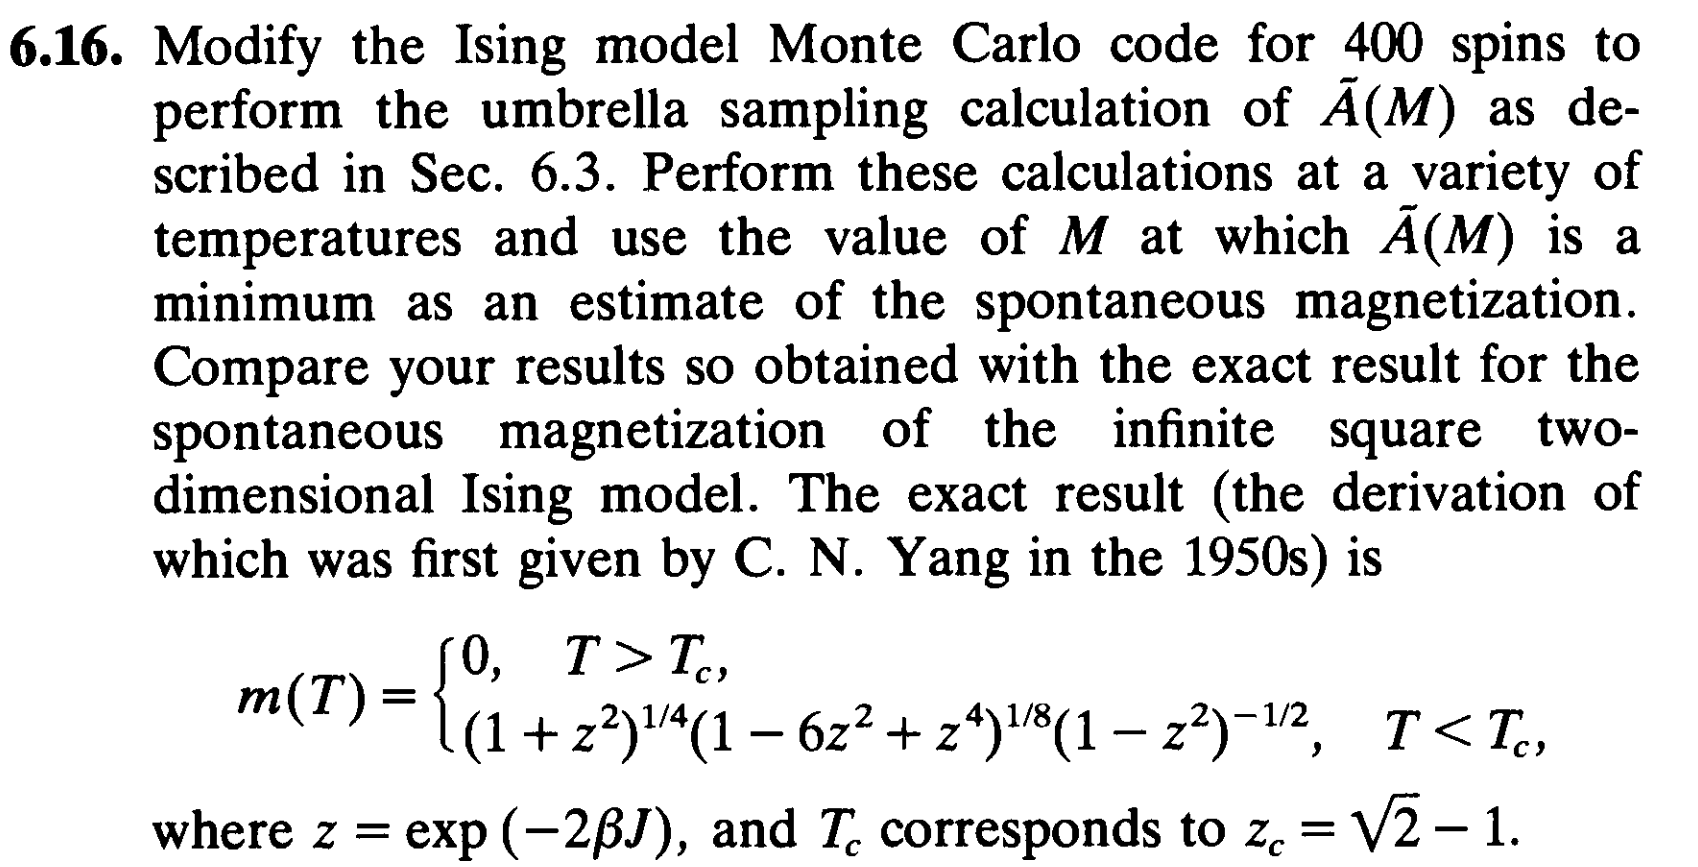

# Answer to Question G

In [ ]:
class Ising2DUmbrella(Ising2D):
    """Inherits from Ising2D and implements umbrella sampling."""
    def monte_carlo_step(self, beta, target_magnetization=None, k_bias=None):
        """Modified Monte Carlo step for umbrella sampling."""
        for _ in range(self.N):
            i = random.randrange(self.L)
            j = random.randrange(self.L)
            delta_E = calculate_delta_E_numba(self.lattice, self.L, self.J, self.H, i, j)

            delta_V_bias = 0.0
            if target_magnetization is not None and k_bias is not None:
                current_magnetization_total = calculate_magnetization_numba(self.lattice)
                flipped_lattice = self.lattice.copy()
                flipped_lattice[i, j] *= -1
                new_magnetization_total = calculate_magnetization_numba(flipped_lattice)
                delta_V_bias = 0.5 * k_bias * ((new_magnetization_total - target_magnetization)**2 -
                                               (current_magnetization_total - target_magnetization)**2)

            if delta_E + delta_V_bias < 0 or random.random() < np.exp(-beta * (delta_E + delta_V_bias)):
                self.lattice[i, j] *= -1

    def run_umbrella_sampling(self, T, num_steps, equilibration_steps,
                                target_magnetizations, k_bias):
        beta = 1.0 / T
        histograms = []
        magnetizations_list = []

        for M0 in tqdm(target_magnetizations, desc="Umbrella Windows"):
            self.__init__(self.L, J=self.J, H=self.H) # Reset lattice for each window
            print(f"Equilibrating for target magnetization M0 = {M0:.2f}...")
            for _ in range(equilibration_steps):
                self.monte_carlo_step(beta, M0, k_bias)

            magnetizations = []
            print(f"Sampling for target magnetization M0 = {M0:.2f}...")
            for _ in range(num_steps):
                self.monte_carlo_step(beta, M0, k_bias)
                magnetizations.append(self.calculate_magnetization() * self.N) # Store total magnetization
            magnetizations_list.append(np.array(magnetizations))
            hist, bins = np.histogram(magnetizations, bins=50, density=True)
            histograms.append((hist, bins))

        return histograms, magnetizations_list

def calculate_exact_spontaneous_magnetization(T, J=1.0):
    if T >= 2.0 / np.log(1 + np.sqrt(2)) * J: # Critical Temperature Tc for square lattice is approx 2.269 J
        return 0.0
    else:
        beta = 1.0 / T
        z = np.exp(-2 * beta * J)
        return (1 + z**2)**(1/4) * (1 - 6 * z**2 + z**4)**(1/8) * (1 - z**2)**(-1/2)



In [ ]:
L = 20
N = L * L
J = 1.0
T_values = np.linspace(1.0, 3.0, 5) # Explore temperatures below and above Tc
num_steps = 5000
equilibration_steps = 2000
k_bias = 10.0
num_windows = 21
magnetization_range = np.linspace(-1.0, 1.0, num_windows) * N
target_magnetizations = magnetization_range

all_estimated_m = []
all_exact_m = []
all_temperatures = []

for T in T_values:
    print(f"\n--- Temperature T = {T:.2f} ---")
    model = Ising2DUmbrella(L, J=J)
    histograms, magnetizations_list = model.run_umbrella_sampling(
        T, num_steps, equilibration_steps, target_magnetizations, k_bias
    )

    # Placeholder for WHAM implementation
    # For now, let's again look at the mean magnetization in the windows
    mean_magnetizations = [np.mean(m) / N for m in magnetizations_list]

    estimated_spontaneous_m = 0.0
    if T < 2.27 * J: # Approximate Tc
        positive_m_means = [m for i, m in enumerate(mean_magnetizations) if target_magnetizations[i] > 1e-6]
        if positive_m_means:
            estimated_spontaneous_m = np.mean(positive_m_means)

    exact_spontaneous_m = calculate_exact_spontaneous_magnetization(T, J)
    print(f"Estimated spontaneous magnetization (crude): {estimated_spontaneous_m:.4f}")
    print(f"Exact spontaneous magnetization: {exact_spontaneous_m:.4f}")

    all_estimated_m.append(estimated_spontaneous_m)
    all_exact_m.append(exact_spontaneous_m)
    all_temperatures.append(T)

plt.figure(figsize=(10, 6))
plt.plot(all_temperatures, all_estimated_m, 'o-', label='Estimated (Crude)')
plt.plot(all_temperatures, all_exact_m, '-', label='Exact')
plt.xlabel('Temperature (T/J)')
plt.ylabel('Spontaneous Magnetization (m)')
plt.title('Estimated vs. Exact Spontaneous Magnetization')
plt.legend()
plt.grid(True)
plt.show()


--- Temperature T = 1.00 ---


Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

Umbrella Windows:   0%|          | 0/21 [00:00<?, ?it/s]

Equilibrating for target magnetization M0 = -400.00...
Sampling for target magnetization M0 = -400.00...
Equilibrating for target magnetization M0 = -360.00...
Sampling for target magnetization M0 = -360.00...
Equilibrating for target magnetization M0 = -320.00...
Sampling for target magnetization M0 = -320.00...
Equilibrating for target magnetization M0 = -280.00...
Sampling for target magnetization M0 = -280.00...
Equilibrating for target magnetization M0 = -240.00...
Sampling for target magnetization M0 = -240.00...
Equilibrating for target magnetization M0 = -200.00...
Sampling for target magnetization M0 = -200.00...
Equilibrating for target magnetization M0 = -160.00...
Sampling for target magnetization M0 = -160.00...
Equilibrating for target magnetization M0 = -120.00...
Sampling for target magnetization M0 = -120.00...
Equilibrating for target magnetization M0 = -80.00...
Sampling for target magnetization M0 = -80.00...
Equilibrating for target magnetization M0 = -40.00...
Sam

# Question H 